In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from pes_bs_utils import parse_energy_cc, parse_energy_hf
from scipy.interpolate import InterpolatedUnivariateSpline as sp

atoms_path="/home/giorgiod/MRCC_interface/Atoms/"
basisSets=['sto-3G', 'sto-6G','3-21G','6-31G*','def2-TZVP','def2-QZVPP','cc-pvtz','aug-cc-pVQZ']
atoms="H,He,Li,Be,B,C,N,O,F,Ne,Na,Mg,Al"
atoms=atoms.split(',')

atoms_mol={'HAl':['H','Al'],'HeMg':['He','Mg'],'LiNa':['Li','Na'],\
           'BeNe':['Be','Ne'],'BF':['B','F'],'CO':['C','O'],'NN':['N','N']}
def energy(bs,targ,ref,hf=False):
    logfile=atoms_path+'{}/{}/{}_at_{}/run.log'.format(bs,targ,targ,ref)
    if hf:
            return parse_energy_hf(logfile)
    return parse_energy_cc(logfile)
def bsc(ref,target):
    return \
    energy('def2-QZVPP',atoms_mol[target][0],atoms_mol[ref][0])\
    +energy('def2-QZVPP',atoms_mol[target][1],atoms_mol[ref][1]) \
    -energy('def2-QZVPP',atoms_mol[target][0],atoms_mol[target][0])\
    -energy('def2-QZVPP',atoms_mol[target][1],atoms_mol[target][1])
bsc('NN','CO')

0.01234583452800564

In [17]:
dt_qzvpp=pd.read_pickle('data_def2_qzvpp')
hfmp2dft=pd.read_pickle('hfmp2dft_def2qzvpp')  #pes at hf, mp2 ,PBE and B3LYP
hfmp2dft[:10]

,calc,distance,energy,mol
0,PBE,1.3,-123.006279,BF
1,PBE,1.4,-123.494394,BF
2,PBE,1.5,-123.842846,BF
3,PBE,1.6,-124.089114,BF
4,PBE,1.7,-124.260711,BF
5,PBE,1.8,-124.379879,BF
6,PBE,1.9,-124.461850,BF
7,PBE,2.0,-124.516687,BF
8,PBE,2.1,-124.551409,BF
9,PBE,2.2,-124.571673,BF


Now we only consider alchemies from NN to CO :: from CO to NN and BF :: from BF to CO <br>
2^nd and 4^th order alchemy VS HF and MP2, true CCSD of the target as a reference.



In [3]:
# for masses reference  https://physics.nist.gov/cgi-bin/Compositions/stand_alone.pl
m_B=10.806
m_C=12.0096
m_N=14.006
m_O=15.999
m_F=18.998

# https://physics.nist.gov/cgi-bin/cuu/Value?u|search_for=physchem_in! ++ https://physics.nist.gov/cgi-bin/cuu/Value?me  
dalton_to_au=  1.660e-27 / 9.109e-31


mu_nn=12766.4683422
mu_nn=m_N/2 *dalton_to_au
mu_co=m_C*m_O/(m_C+m_O)*dalton_to_au
mu_bf=m_B*m_F/(m_B+m_F)*dalton_to_au
lightspeed=137.035999753
planck=6.28318530718
centimeter=188972613.392
def to_cm(k,Mu):
    return (k/Mu)**0.5*centimeter/planck/lightspeed
print(mu_nn,mu_bf,mu_co)

12762.081457898783 12552.657457934376 12501.650854791682


In [4]:
def sppes(scan):
    points=np.linspace(1.3,3.2,20)
    target_pts=np.linspace (1.3,3.2,1901) # points 20 in 1.3-3.2 (1.9bohrs)
    bspline=sp(points,scan)
    return bspline(target_pts)

In [22]:
def Plot(ax,ref,target):
    target_pts=np.linspace (1.3,3.2,1901)
    spline_true=sppes(dt_qzvpp.query("alchemy==0 &ref==@ref & target==@target").e_ccsd )
    spline_alch2=sppes(dt_qzvpp.query("alchemy==2 &ref==@ref & target==@target").e_alch )-bsc('NN','CO')
    spline_alch2_noc=sppes(dt_qzvpp.query("alchemy==2 &ref==@ref & target==@target").e_alch )
    spline_alch4_noc=sppes(dt_qzvpp.query("alchemy==4 &ref==@ref & target==@target ").e_alch )
    spline_alch4=sppes(dt_qzvpp.query("alchemy==4 &ref==@ref & target==@target").e_alch )-bsc('NN','CO')
    #
    ax.plot(target_pts,spline_true,label='True CCSD',color='C0')
    ax.plot(target_pts,spline_alch2,label='Alchemy $2^{nd}$ order',color='C1')
    ax.plot(target_pts,spline_alch2_noc,':',label='Alchemy $2^{nd}$ order no C',color='C2')
    ax.plot(target_pts,spline_alch4,label='Alchemy $4^{nd}$ order',color='C3')
    #plt.show()
    ax.xlim(1.8,2.4)
    ax.ylim(min(spline_true)-.05,spline_alch2_noc[500]+0.05)
    ax.legend()
    ax.title("from {} to {}".format(ref,target))

In [7]:
#frequencies
def freq(spline,Mu):
    min_true=np.argmin(spline)
    k_true=(spline[min_true-1]+spline[min_true+1]-2*spline[min_true])*1.e+6
    return to_cm(k_true,Mu)

In [8]:
freq(spline_alch2,mu_co),freq(spline_true,mu_co)

(2270.953695301357, 2234.1902600246212)

AttributeError: 'AxesSubplot' object has no attribute 'xlim'

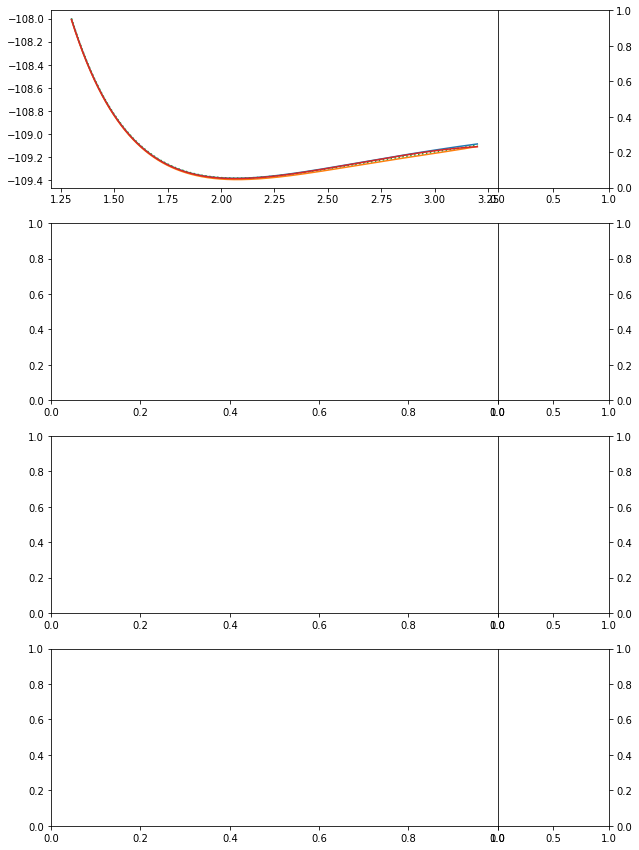

In [23]:
subplspec={'width_ratios' :[4,1], 'wspace':0}
fig,axs=plt.subplots(4,2,figsize=(10,15),gridspec_kw=subplspec)
for ax in axs.T[:][1]: ax.yaxis.tick_right()
    
Plot(axs[0][0],'CO','NN')
Plot(axs[0][1],'CO','NN')
Plot(axs[0][2],'CO','NN')
Plot(axs[0][3],'CO','NN')
axs[0][1].axhline(freq(spline_true,mu_co),color='C0')
axs[0][1].axhline(freq(spline_alch2,mu_co),color='C1')
axs[0][1].axhline(freq(spline_alch4,mu_co),color='C2')
plt.savefig('freq_1.png')